In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy import ndimage
from skimage import data, io, color
from skimage.transform import resize, rescale, downscale_local_mean
from pandas import DataFrame

plt.rcParams['figure.figsize'] = [10, 10]

def show_image(image, title):
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def rrmse(observed, ideal):
    return np.sqrt((1 / observed.shape[0]**2) * np.sum((observed-ideal)**2) / np.sum(ideal**2)) * 100.0

def decimation_matrix(l, m):
    d_matrix = np.zeros((m**2, l**2), dtype=np.float32)

    tile = np.repeat((1, 0, 1), (2, l - 2, 2)) # assuming taking 2 neighbours per dimension
    t_len = tile.shape[0]
    d = l // m
    r_offset = m**2 // 2
    c_offset = l**2 // 2

    for p in np.arange(l//4): # divide by 4 as 4 neighbours total
        p_offset = p * l
        for q in np.arange(m):
            d_matrix[q+ p_offset//2, q*d + p_offset*2 : q*d+t_len + p_offset*2] = tile # top-left quadrant
            d_matrix[q+r_offset + p_offset//2, q*d+c_offset + p_offset*2: q*d+t_len+c_offset + p_offset*2] = tile # bottom-right quadrant
    return d_matrix

# produces convolution matrix of size l**2 by l**2, where each row is populated by the convolution kernel values at the appropriate neighbours
# note: assumes kernel is a two-dimensonal numpy array of some size n by n
def convolution_matrix(l, kernel):
    
    conv = np.zeros((l**2, l**2), dtype=np.float32)
    full_supp = kernel.shape[0] # assumed square
    half_supp = (full_supp - 1) // 2

    for conv_row in np.arange(l**2):

        row, col = (conv_row // l, conv_row % l)

        for k_row in np.arange(-(half_supp), half_supp + 1):
            # map "kernel row" to rows in conv
            mapped_row = row + k_row
            # ignore any out of bounds rows
            if mapped_row >= 0 and mapped_row < l:
                linear_col = col - half_supp
                # truncate negative columns
                mapped_col_start = max(linear_col, 0)
                # truncate columns which exceed the l dimension
                mapped_col_end = min(linear_col + full_supp, l)
                # left trimming for kernels when overlapping out of bounds region in conv (col < 0)
                left = np.absolute(col - half_supp) if linear_col < 0 else 0
                # right trimming for kernels when overlapping out of bounds region in conv (col >= l)
                right = linear_col + full_supp - l if linear_col + full_supp >= l else 0 
                # copy over kernel row for current k_row, possibly including trimming for out of bounds coordinates
                conv[conv_row][mapped_row * l + mapped_col_start : mapped_row * l + mapped_col_end] = kernel[k_row + half_supp][left: left + full_supp - right]
    return conv

#### Area under trimmed PSF as a percentage of the full PSF

In [2]:
# l = 100
# # all time steps direct psf
# filename = "../data/direct_psf_ts_0_29.bin"
# x_psf = np.fromfile(filename, dtype=np.float32)
# x_psf = x_psf.reshape(l, l)
# # x_psf /= np.max(x_psf)

# x_psf_sum = np.sum(x_psf)
# # print(f"Full PSF sum under curve: {x_psf_sum}")

# psf_supports = []
# area_under_curve = []

# for s in np.arange(2, 51, 1): # 51
#     psf_min = l//2 - (s - 1)
#     psf_max = l//2 + s
#     support = psf_max - psf_min
#     trimmed_psf = x_psf[psf_min:psf_max, psf_min:psf_max]
#     # trimmed_psf = trimmed_psf/np.sum(trimmed_psf)
#     # print(np.sum(trimmed_psf))
#     psf_area_percent = np.sum(trimmed_psf)/x_psf_sum * 100
#     print(f"PSF size: {support}x{support} => area under curve: {psf_area_percent}%")
#     psf_supports.append(support)
#     area_under_curve.append(psf_area_percent)
#     # print(trimmed_psf.shape)
    
# plt.plot(psf_supports, area_under_curve)
# plt.title("Trimmed PSF Support versus Area Under Curve")
# plt.xlabel("PSF Support")
# plt.ylabel("Area (as percentage of full PSF)")
# plt.show()

#### Brute force estimation of beta versus PSF support

In [3]:
# psf_supports = np.arange(2, 51, 1) # 3 .. 99, taking all odd values in between
# np.set_printoptions(suppress=True)
# betas = np.geomspace(1, 50, num=100)

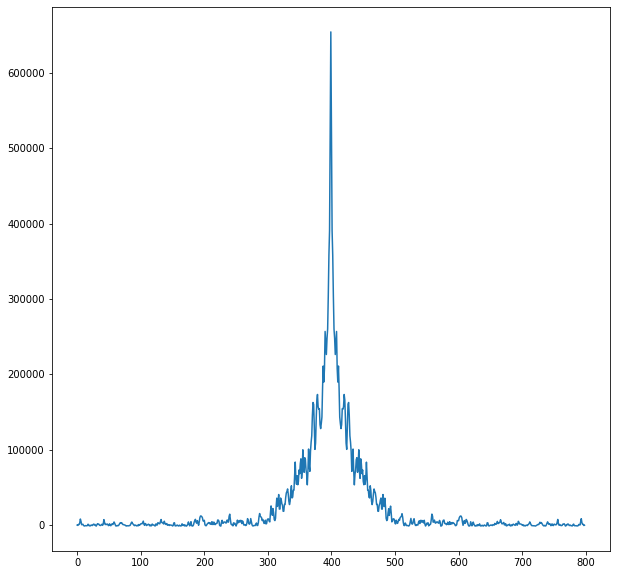

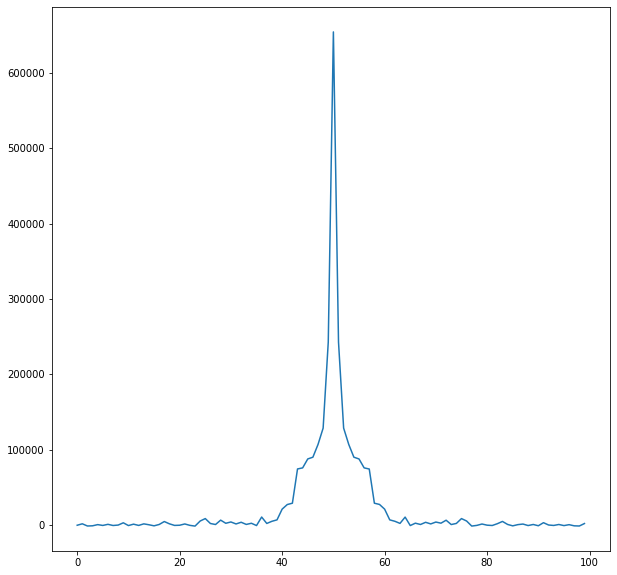

Processing support 19 with beta 0.1
Processing support 19 with beta 0.12440716249808176
Processing support 19 with beta 0.1547714208082412
Processing support 19 with beta 0.19254673298549857
Processing support 19 with beta 0.23954192699001672
Processing support 19 with beta 0.29800731436150657
Processing support 19 with beta 0.37074244383388877
Processing support 19 with beta 0.4612301545497855
Processing support 19 with beta 0.5738033478609053
Processing support 19 with beta 0.7138524633927497
Processing support 19 with beta 0.8880835941295776
Processing support 19 with beta 1.1048396000675884
Processing support 19 with beta 1.3744995965992417
Processing support 19 with beta 1.7099759466766964
Processing support 19 with beta 2.12733255466019
Processing support 19 with beta 2.646554068150696
Processing support 19 with beta 3.29250282016383
Processing support 19 with beta 4.096109333735141
Processing support 19 with beta 5.09585339491897
Processing support 19 with beta 6.339606613680861

In [4]:
dataframe = DataFrame()

psf_supports = np.arange(10, 11, 1) # 3 .. 7, taking all odd values in between
betas = np.geomspace(0.1, 500.0, num=40)

dataframe["Beta"] = betas

timesteps = 30 # total timesteps
timesteps_per_y = 5
l = 100
m = 50
n = timesteps // timesteps_per_y
w = np.ones(n) # y image weightings, eventually driven by visibility weights

# all time steps direct image
# filename = "../data/direct_image_ts_0_29.bin"
# x_true = np.fromfile(filename, dtype=np.float32)
# x_true = x_true.reshape(l, l)
# x_true = normalise(x_true)

filename = "../data/direct_image_ts_0_29_800x800.bin"
x_true = np.fromfile(filename, dtype=np.float32)
x_true = resize(x_true.reshape(800, 800), (l, l), anti_aliasing=False, order=1)

# all time steps direct psf
# filename = "../data/direct_psf_ts_0_29.bin"
# x_psf = np.fromfile(filename, dtype=np.float32)
# x_psf = x_psf.reshape(l, l)
# x_psf /= np.max(x_psf)

filename = "../data/direct_psf_ts_0_29_800x800.bin"
x_psf = np.fromfile(filename, dtype=np.float32).reshape(800, 800)[1:, 1:]
plt.plot(x_psf[x_psf.shape[0]//2])
plt.show()
# show_image(x_psf, "Untrimmed PSF")
x_psf = resize(x_psf, (l-1, l-1), anti_aliasing=False, order=1)
x_psf = np.pad(x_psf, ((1, 0), (1, 0))) # pad with new 0th row/col to ensure trimming from centre
# show_image(x_psf, "Untrimmed PSF - RESIZED")
plt.plot(x_psf[x_psf.shape[0]//2])
plt.show()

# Storing all low-res images as layered stack
y = np.zeros((n, m, m))

# batched time steps direct images
for i in np.arange(n):
    filename = f"../data/direct_image_ts_{i * timesteps_per_y}_{i * timesteps_per_y + timesteps_per_y - 1}.bin"
    y[i] = np.fromfile(filename, dtype=np.float32).reshape(m, m)
    y[i] = normalise(y[i])

# Decimation matrix
d = decimation_matrix(l, m) # takes the sum of 4 l neighbours to form 1 m pixel

# Sharpening matrix (laplacian)
laplacian = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
s = convolution_matrix(l, laplacian)

for psf_support in psf_supports:
    
    errors = []
    
    for beta in betas:

        β = beta # sharpening factor

        trim_half_len = psf_support
        psf_min = l//2 - (trim_half_len - 1)
        psf_max = l//2 + trim_half_len
        support = psf_max - psf_min
        x_psf_trim = x_psf[psf_min:psf_max, psf_min:psf_max]
        # plt.plot(x_psf_trim[x_psf_trim.shape[0]//2])
        # plt.show()
        x_psf_trim = x_psf_trim/np.sum(x_psf_trim)

        print(f"Processing support {support} with beta {β}")

        # Blur matrix (psf)
        h = convolution_matrix(l, x_psf_trim)

        b = np.zeros(l**2, dtype=np.float32)

        for i in np.arange(n):
            b += np.matmul(w[i] * h.T, np.matmul(d.T, y[i].flatten()))                  
        # show_image(normalise(b.reshape(l, l)), "B")

        lhs = β * np.matmul(s.T, s)
        rhs = (h.T @ d.T @ d @ h) * np.sum(w)
        a = lhs + rhs
        # show_image(a.reshape(l**2, l**2), "A")

        x = np.linalg.solve(a, b)
        x = x.reshape(100, 100)
        error = rrmse(normalise(x), normalise(x_true))
        # print(f"RRMSE: Solved X and True X -> {error}")
        errors.append(error)

        if beta == betas[-1]: # if last iteration
            print("Last iteration...")
            dataframe[f"{support}x{support}"] = errors

        # show_image(normalise(x), "Solved X")
        # show_image(normalise(x_true), "True X")
    
# Finally, write the results to a spreadsheet...
# dataframe.to_excel('../beta_bruteforce.xlsx', sheet_name='beta_vs_rrmse', index=False)
print(dataframe)

In [5]:
# plt.plot(betas, errors)

In [6]:
print("Finished")

Finished
